In [1]:
dataset <- "ARPAE"
state <- "Emilia-Romagna"
match_dist <- 15000


In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)

source("src/database/tools.R")
source("src/database/insert.R")
source("src/database/write.R")
source("src/database/startup.R")
source("src/database/plot.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")
source("src/merging/analysis.R")
source("src/merging/display.R")
source("src/merging/combining.R")

conns <- load_dbs()
state_boundaries <- query_boundary(conns$stations, state, "state")


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



In [3]:
ds_meta <- query_checkpoint_meta(dataset, "qc1", conns$data) |>
    collect()
scia_meta <- query_checkpoint_meta("SCIA", "qc1", conns$data) |>
    collect() |>
    st_md_to_sf() |>
    st_filter(state_boundaries |> st_buffer(dist = 1000), .predicate = st_within) |>
    st_drop_geometry() |>
    filter(!state %in% c("Liguria", "Piemonte", "Lombardia", "Veneto", "Marche", "Toscana"), !(network %in% c("Sinottica", "Mareografica")))
metadata <- bind_rows(ds_meta, scia_meta) |> mutate(key = row_number())
metadata_db <- copy_to(conns$data, metadata, "metas_tmp", overwrite = TRUE)

sensor_matches <- close_matches(metadata_db, match_dist, conns$stations)

data <- query_checkpoint_data(c(dataset, "SCIA"), "qc1", conns$data) |>
    filter(valid) |>
    left_join(metadata_db |> select(dataset, sensor_key, key), by = c("dataset", "sensor_key"))

var_matches <- series_matches(data, sensor_matches, metadata_db)


In [7]:
# analysis <- series_matches_analysis(var_matches, data, metadata_db, matches_offsets = 0L)
# analysis |> write_xlsx_analysis(file.path("notebooks", "integrazioni_regionali", state, "raw_analysis.xlsx"), starts_with("user_code"))
analysis <- read_parquet(file.path("notebooks", "integrazioni_regionali", state, "raw_analysis.parquet"))


- onlyagg: 843
- noagg: 843
- orig: 843
- noagg_cet: 842
- hourly: 843
- hourly_noagg: 843

In [8]:
analysis |>
    filter(f0 > 0.5) |>
    nrow()


[1] 843

- onlyagg: ~650
- noagg: 718
- orig: 654
- noagg_cet: 601
- hourly: 658
- hourly_noagg: 718

In [9]:
analysis |>
    filter(f0 > 0.8) |>
    nrow()


[1] 718

In [10]:
source(file.path("notebooks", "integrazioni_regionali", state, "procedures", "match_taggers.R"))
source("src/merging/tagging.R")
tagged_analysis <- tag_same_series(analysis) |>
    tag_mergeable() |>
    default_logic(require_all = TRUE)
tagged_analysis |> write_xlsx_analysis(file.path("notebooks", "integrazioni_regionali", state, "tagged_analysis.xlsx"), starts_with("tag_"))


ERROR: Error in source(file.path("notebooks", "integrazioni_regionali", state, : notebooks/integrazioni_regionali/Emilia-Romagna/procedures/match_taggers.R:26:25: ')' inatteso
25:                         
26:                         )
                            ^


In [44]:
analysis |>
    filter(sensor_key_x == 3407L, sensor_key_y == 3417L, dataset_x == "SCIA", dataset_y == "SCIA")


key_x,key_y,variable,maeT,delT,sdT,valid_days_x,valid_days_y,valid_days_inters,valid_days_union,...,series_first_y,series_last_y,delH,norm_name_x,norm_name_y,strSym,common_period,common_period_vs_x,common_period_vs_y,selfdiff
<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<date>,<date>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
583,586,-1,1.6644464,-1.6588659,1.2632299,2351,6330,2222,6459,...,2004-05-22,2021-12-14,-3,zibello,zibello,1,6415,0.9783438,1,1.2153020
583,586,1,0.6482898,-0.2980648,0.8646756,2351,6330,2222,6459,...,2004-05-22,2021-12-14,-3,zibello,zibello,1,6415,0.9783438,1,0.9430147


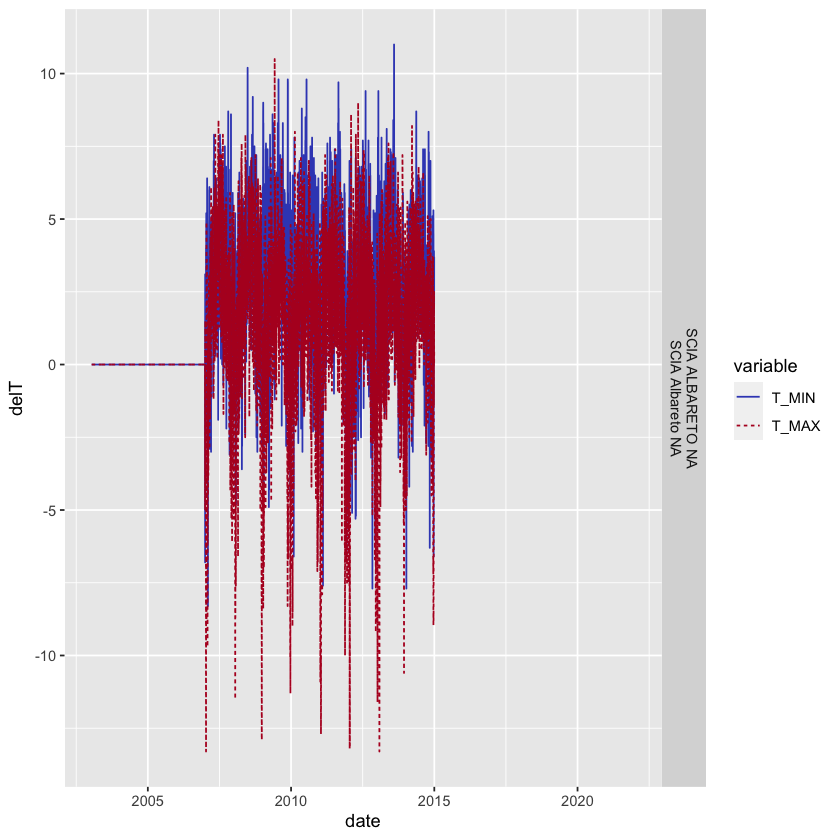

In [46]:
analysis |>
    filter(sensor_key_x == 15L, sensor_key_y == 3553L, dataset_x == "SCIA", dataset_y == "SCIA") |>
    plot_diffs(data)


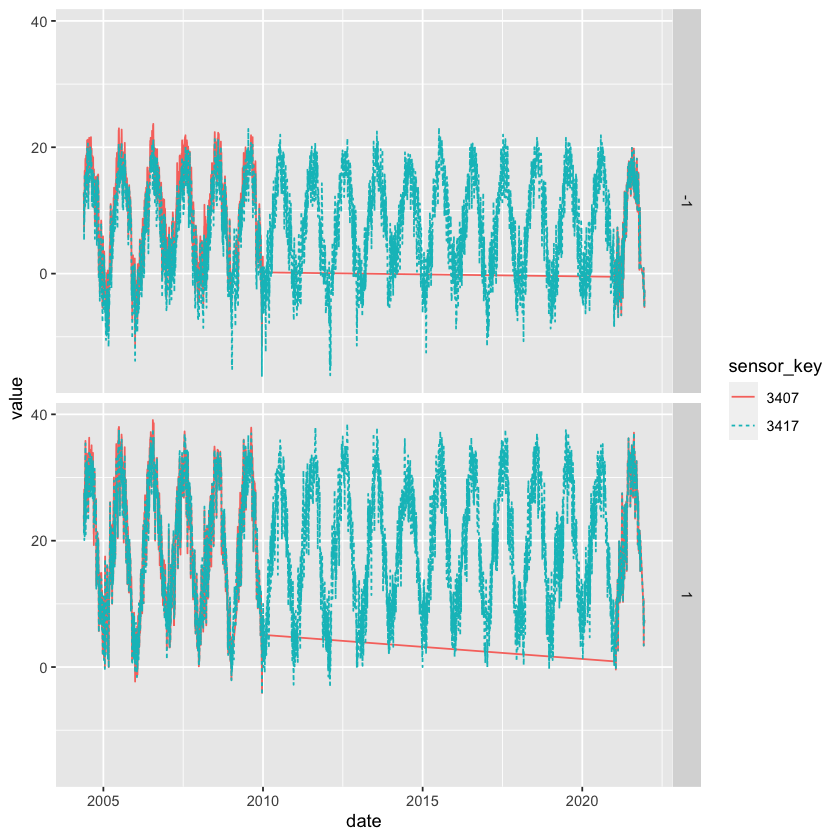

In [12]:
ids <- tibble(sensor_key = c(3417L, 3407L), dataset = c("SCIA", "SCIA"))
plot_stations(ids, data, TRUE)


In [35]:
library(lubridate)
albareto <- vroom::vroom(fs::path_abs("~/Downloads/dexter.csv"), skip = 4L, n_max = 34949L - 4L, col_names = c("start", "end", "TMAX"), col_types = "ccd", col_select = 1:3, delim = ",") |>
    as_tibble() |>
    drop_na(TMAX) |>
    mutate(across(c("start", "end"), ~ ymd_hms(.)), name = "Albareto") |>
    filter(hour(start) == 0L)

albareto_parma <- vroom::vroom(fs::path_abs("~/Downloads/dexter.csv"), skip = 34952L, n_max = 39321L - 34952L, col_names = c("start", "end", "TMAX"), col_types = "ccd", col_select = 1:3, delim = ",") |>
    as_tibble() |>
    drop_na(TMAX) |>
    mutate(across(c("start", "end"), ~ ymd_hms(.)), name = "Albareto Parma") |>
    filter(hour(start) == 0L)


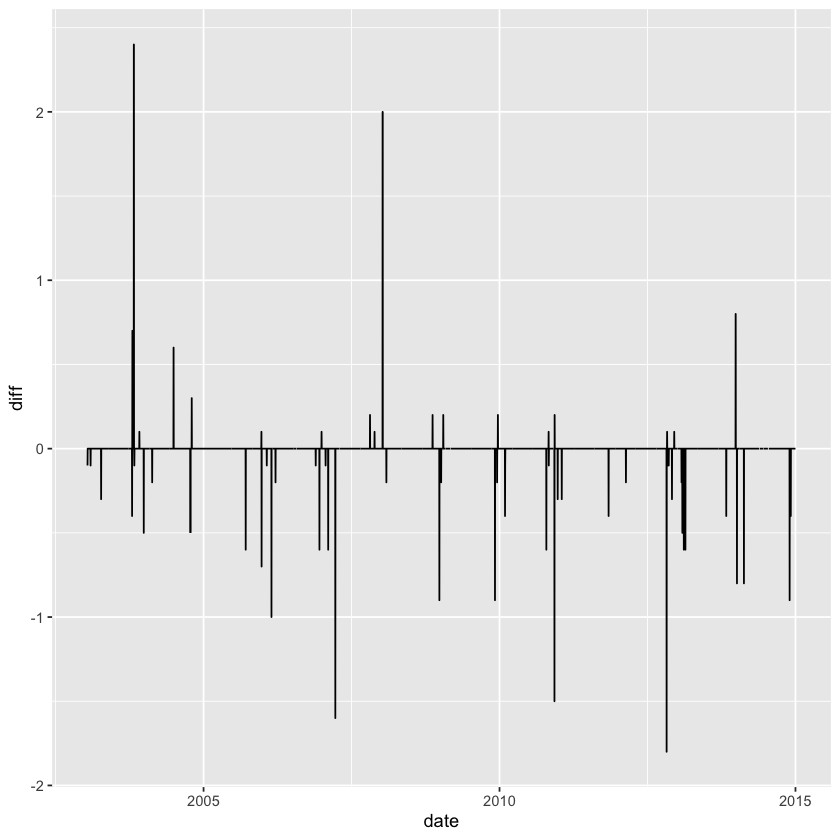

In [52]:
library(tidyr, warn.conflicts = FALSE)
albs <- bind_rows(albareto, albareto_parma) |>
    mutate(date = as.Date(start)) |>
    select(date, name, value = TMAX)

albs |>
    pivot_wider(names_from = name, values_from = value) |>
    mutate(diff = `Albareto Parma` - `Albareto`) |>
    ggplot(aes(x = date, y = diff)) +
    geom_line()


In [48]:
albareto_scia <- data |> filter(sensor_key == 15L, dataset == "SCIA", variable == 1L)
albareto_parma_scia <- data |> filter(sensor_key == 3553L, dataset == "SCIA", variable == 1L)


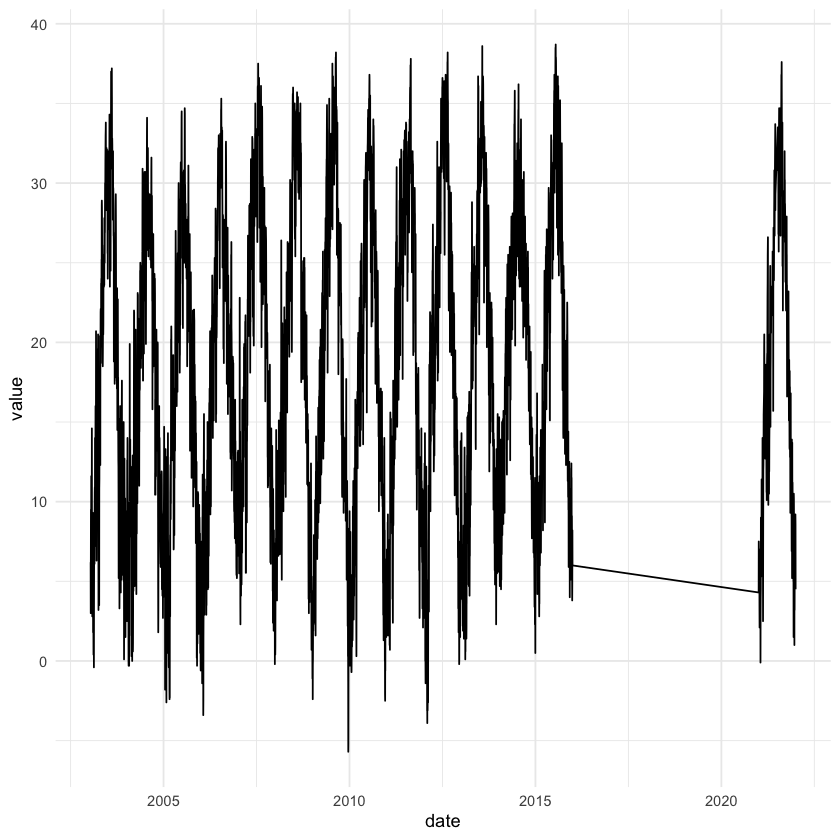

In [59]:
ggplot(data = albareto_parma_scia, aes(x = date, y = value)) +
    geom_line() +
    theme_minimal()

Warning message:
"Removed 673 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 673 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 673 rows containing missing values (`geom_line()`)."


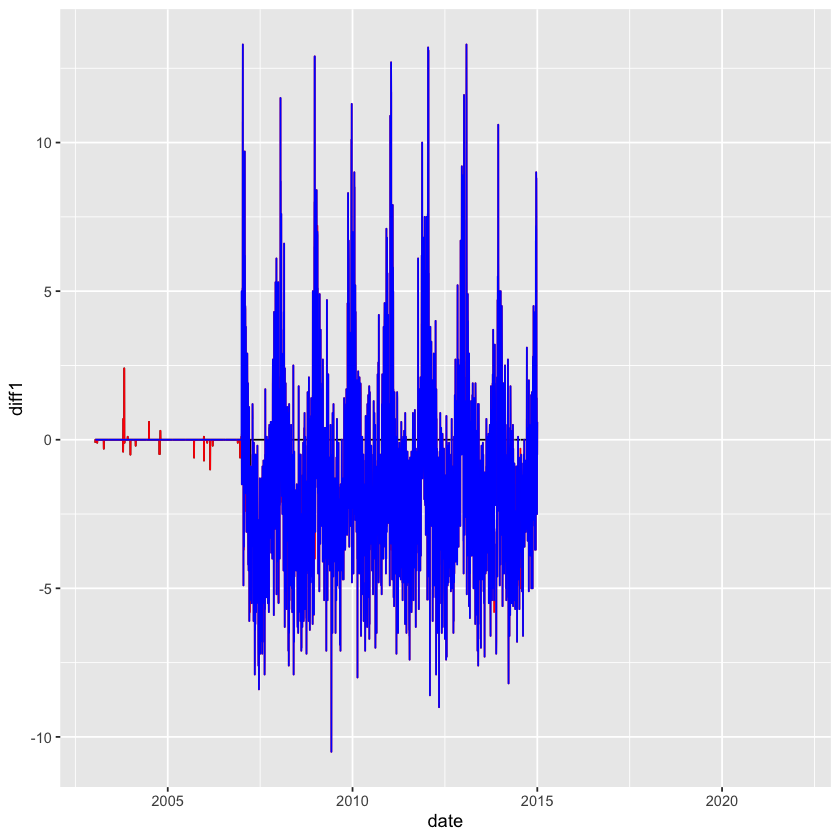

In [60]:
bind_rows(
    albs,
    albareto_parma_scia |>
        select(date, value, name = sensor_key) |>
        mutate(name = "scia") |>
        collect()
) |> pivot_wider(names_from = name, values_from = value) |>
    mutate(diff1 = `Albareto Parma` - `Albareto`, diff2 = `Albareto Parma` - scia, diff3 = `Albareto` - scia) |>
    ggplot(aes(x = date)) +
    geom_line(aes(y = diff1), color = "black") +
    geom_line(aes(y = diff2), color = "red") +
    geom_line(aes(y = diff3), color = "blue")


In [42]:
analysis |>
    filter(sensor_key_x == 15L, sensor_key_y == 3553L) |>
    select(starts_with("lon"), starts_with("lat"), name_x, name_y)


lon_x,lon_y,lat_x,lat_y,name_x,name_y
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
9.69845,9.698466,44.44688,44.44685,ALBARETO,Albareto
9.69845,9.698466,44.44688,44.44685,ALBARETO,Albareto


In [65]:
source("notebooks/integrazioni_regionali/Emilia-Romagna/procedures/load_daily.R")

In [66]:
load_dext3r()

# Source:   SQL [?? x 6]
# Database: DuckDB v0.9.2 [root@Darwin 23.2.0:R 4.3.2/:memory:]
   start                     stop                value variable name  date      
   <chr>                     <chr>               <chr> <chr>    <chr> <date>    
 1 2003-01-31 00:00:00+00:00 2003-02-01 00:00:0~ -7.10 minima   Alba~ 2003-01-31
 2 2003-02-25 00:00:00+00:00 2003-02-26 00:00:0~ -10.~ minima   Alba~ 2003-02-25
 3 2003-03-06 00:00:00+00:00 2003-03-07 00:00:0~ -0.20 minima   Alba~ 2003-03-06
 4 2003-03-22 00:00:00+00:00 2003-03-23 00:00:0~ -1.20 minima   Alba~ 2003-03-22
 5 2003-04-01 00:00:00+00:00 2003-04-02 00:00:0~ 5.00  minima   Alba~ 2003-04-01
 6 2003-04-23 00:00:00+00:00 2003-04-24 00:00:0~ 1.90  minima   Alba~ 2003-04-23
 7 2003-05-12 00:00:00+00:00 2003-05-13 00:00:0~ 8.00  minima   Alba~ 2003-05-12
 8 2003-05-25 00:00:00+00:00 2003-05-26 00:00:0~ 6.00  minima   Alba~ 2003-05-25
 9 2003-05-26 00:00:00+00:00 2003-05-27 00:00:0~ 8.10  minima   Alba~ 2003-05-26
10 2003-05-29 00:00: